                   shrid2  _mean_p_miss  _core_p_miss  _target_weight_share  \
0  11-01-001-00001-000002           0.0           0.0                   1.0   
1  11-01-001-00001-000005           0.0           0.0                   1.0   
2  11-01-001-00001-000006           0.0           0.0                   1.0   
3  11-01-001-00001-000007           0.0           0.0                   1.0   
4  11-01-001-00001-000009           0.0           0.0                   1.0   

   _target_group_max_weight_share  dmsp_max_light  dmsp_total_light  \
0                             1.0               0                 0   
1                             1.0               0                 0   
2                             1.0               0                 0   
3                             1.0               0                 0   
4                             1.0               0                 0   

   dmsp_total_light_cal  dmsp_mean_light  dmsp_mean_light_cal  dmsp_num_cells  \
0             34.

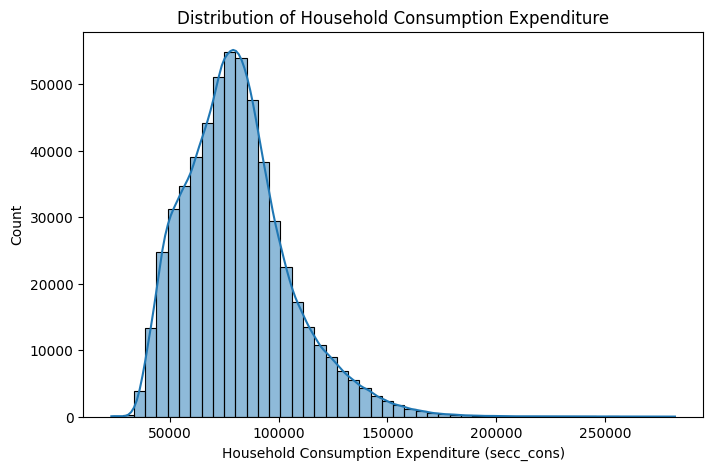

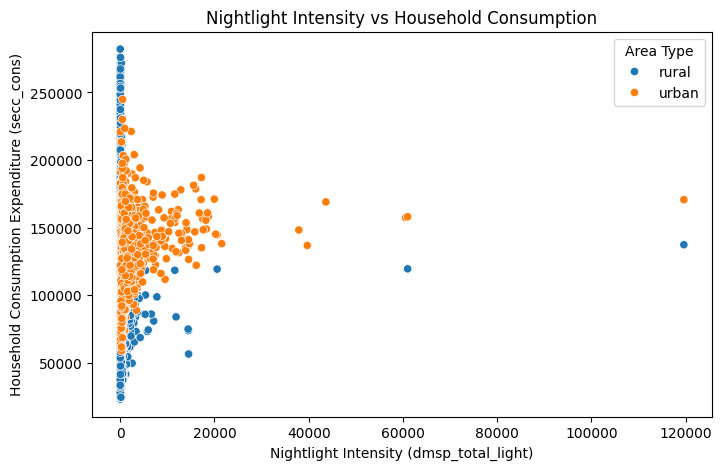

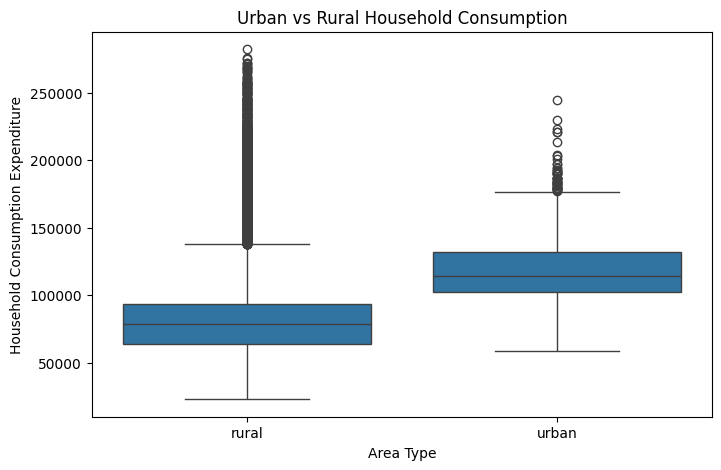

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (Modify the file path accordingly)
df = pd.read_csv("/Users/bishmaybarik/Library/CloudStorage/OneDrive-ShivNadarInstitutionofEminence/nightlight_atlas/01_data/02_processed/secc_combined_updated.csv")  # Replace with actual file path

# Display first few rows
print(df.head())

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Summary statistics
print("\nSummary Statistics:\n", df.describe())

# Plot histogram of household consumption
plt.figure(figsize=(8, 5))
sns.histplot(df["secc_cons"], bins=50, kde=True)
plt.xlabel("Household Consumption Expenditure (secc_cons)")
plt.ylabel("Count")
plt.title("Distribution of Household Consumption Expenditure")
plt.show()

# Scatter plot: Nightlight Intensity vs. Household Consumption
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["dmsp_total_light"], y=df["secc_cons"], hue=df["area_type"])
plt.xlabel("Nightlight Intensity (dmsp_total_light)")
plt.ylabel("Household Consumption Expenditure (secc_cons)")
plt.title("Nightlight Intensity vs Household Consumption")
plt.legend(title="Area Type")
plt.show()

# Boxplot: Urban vs. Rural Consumption
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["area_type"], y=df["secc_cons"])
plt.xlabel("Area Type")
plt.ylabel("Household Consumption Expenditure")
plt.title("Urban vs Rural Household Consumption")
plt.show()


                   shrid2  _mean_p_miss  _core_p_miss  _target_weight_share  \
0  11-01-001-00001-000002           0.0           0.0                   1.0   
1  11-01-001-00001-000005           0.0           0.0                   1.0   
2  11-01-001-00001-000006           0.0           0.0                   1.0   
3  11-01-001-00001-000007           0.0           0.0                   1.0   
4  11-01-001-00001-000009           0.0           0.0                   1.0   

   _target_group_max_weight_share  dmsp_max_light  dmsp_total_light  \
0                             1.0               0                 0   
1                             1.0               0                 0   
2                             1.0               0                 0   
3                             1.0               0                 0   
4                             1.0               0                 0   

   dmsp_total_light_cal  dmsp_mean_light  dmsp_mean_light_cal  ...  year  \
0             34.12080

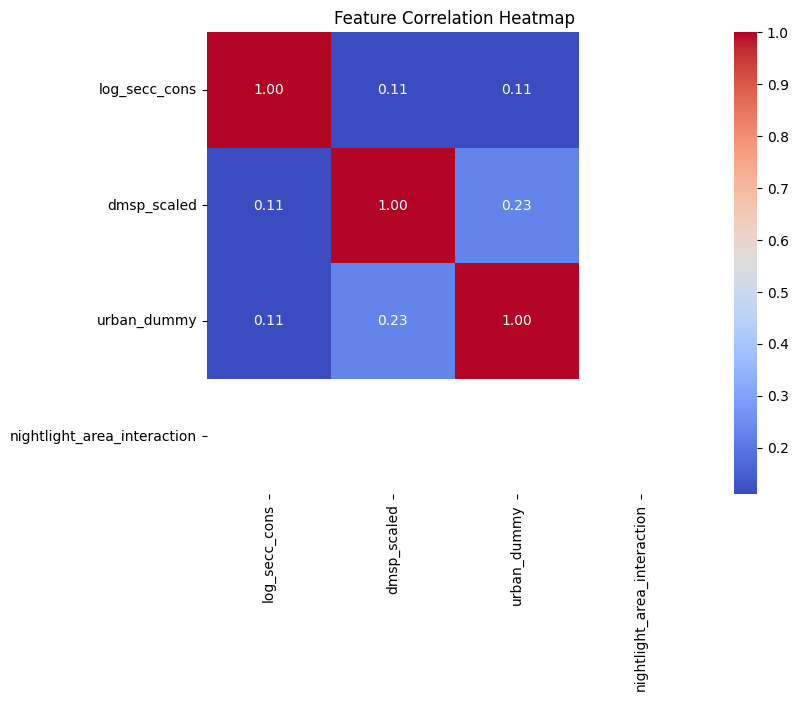

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Apply log transformation to secc_cons
df["log_secc_cons"] = np.log1p(df["secc_cons"])

# Create interaction term: Nightlight intensity × Area Type
df["nightlight_area_interaction"] = df["dmsp_total_light"] * (df["area_type"] == "URBAN").astype(int)

# Scaling Nightlight Intensity
scaler = StandardScaler()
df["dmsp_scaled"] = scaler.fit_transform(df[["dmsp_total_light"]])

# One-hot encoding for area_type
encoder = OneHotEncoder(sparse_output=False, drop="first")  # Drop first to avoid multicollinearity
area_encoded = encoder.fit_transform(df[["area_type"]])
df["urban_dummy"] = area_encoded  # 1 for Urban, 0 for Rural

# Display updated dataset
print(df.head())

# Check correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[["log_secc_cons", "dmsp_scaled", "urban_dummy", "nightlight_area_interaction"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define features and target variable
features = ["dmsp_scaled", "urban_dummy", "nightlight_area_interaction"]
target = "log_secc_cons"  # Predicting log-transformed secc_cons

# Convert to NumPy arrays
X = df[features].values
y = df[target].values

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset shapes
print(f"Training Set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing Set: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training Set: X_train: (453943, 3), y_train: (453943,)
Testing Set: X_test: (113486, 3), y_test: (113486,)


In [4]:
# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape=(3,)),  # First hidden layer
    tf.keras.layers.Dense(32, activation="relu"),  # Second hidden layer
    tf.keras.layers.Dense(1)  # Output layer (predicting log_secc_cons)
])

# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7093/7093 ━━━━━━━━━━━━━━━━━━━━ 3s 361us/step - loss: 9.0121 - mae: 1.1513 - val_loss: 0.0777 - val_mae: 0.2210
Epoch 2/50
7093/7093 ━━━━━━━━━━━━━━━━━━━━ 2s 345us/step - loss: 0.2573 - mae: 0.2364 - val_loss: 0.0763 - val_mae: 0.2199
Epoch 3/50
7093/7093 ━━━━━━━━━━━━━━━━━━━━ 2s 346us/step - loss: 0.1048 - mae: 0.2283 - val_loss: 0.1033 - val_mae: 0.2239
Epoch 4/50
7093/7093 ━━━━━━━━━━━━━━━━━━━━ 2s 343us/step - loss: 0.0866 - mae: 0.2254 - val_loss: 0.0805 - val_mae: 0.2274
Epoch 5/50
7093/7093 ━━━━━━━━━━━━━━━━━━━━ 2s 342us/step - loss: 0.0845 - mae: 0.2245 - val_loss: 0.3957 - val_mae: 0.2357
Epoch 6/50
7093/7093 ━━━━━━━━━━━━━━━━━━━━ 2s 347us/step - loss: 0.1091 - mae: 0.2301 - val_loss: 0.0792 - val_mae: 0.2223
Epoch 7/50
7093/7093 ━━━━━━━━━━━━━━━━━━━━ 2s 339us/step - loss: 0.0860 - mae: 0.2253 - val_loss: 0.0768 - val_mae: 0.2206
Epoch 8/50
7093/7093 ━━━━━━━━━━━━━━━━━━━━ 2s 345us/step - loss: 0.0831 - mae: 0.2240 - val_loss: 0.1113 - val_mae: 0.2331
Epoch 9/50
7093/7093 ━━━━━━━━━━━━━━

3547/3547 ━━━━━━━━━━━━━━━━━━━━ 1s 209us/step - loss: 0.0783 - mae: 0.2235
Test Loss (MSE): 0.0776
Test MAE: 0.2224


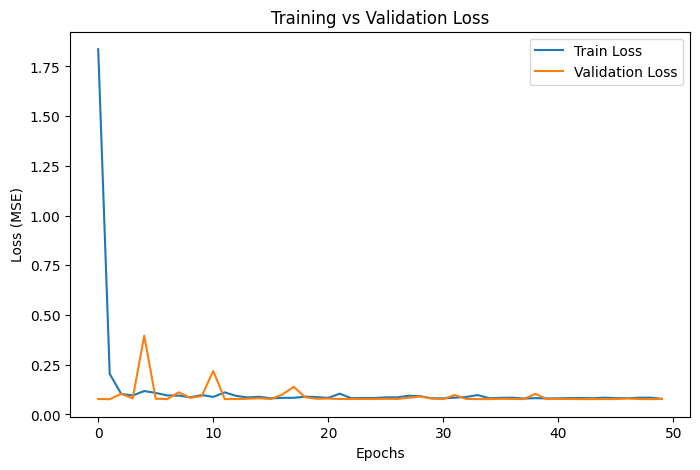

3547/3547 ━━━━━━━━━━━━━━━━━━━━ 1s 210us/step


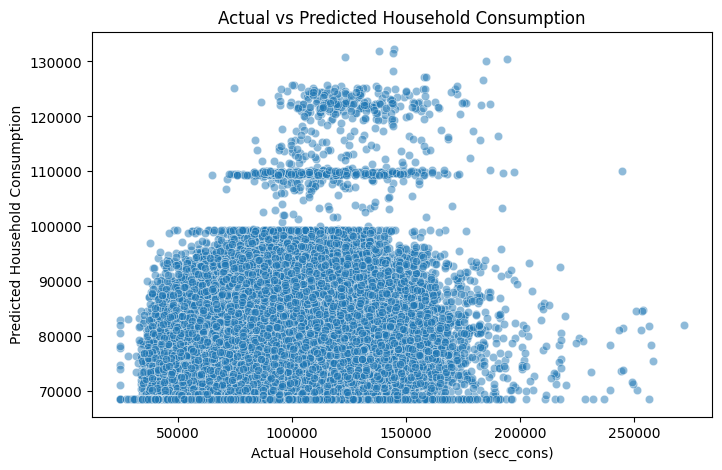

In [5]:
# Evaluate model on test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Plot training history
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Make predictions
y_pred_log = model.predict(X_test)

# Convert log predictions back to original scale
y_pred = np.expm1(y_pred_log)

# Convert actual log values back to original scale
y_test_actual = np.expm1(y_test)

# Scatter plot of predicted vs actual values
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_actual, y=y_pred.flatten(), alpha=0.5)
plt.xlabel("Actual Household Consumption (secc_cons)")
plt.ylabel("Predicted Household Consumption")
plt.title("Actual vs Predicted Household Consumption")
plt.show()


In [9]:
pip install shap


[notice] A new release of pip is available: 24.1.1 -> 25.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
# Create a SHAP explainer
explainer = shap.Explainer(model, X_train)

In [24]:
# Compute SHAP values
shap_values = explainer(X_test)


ExactExplainer explainer: 113487it [03:11, 562.77it/s]                            


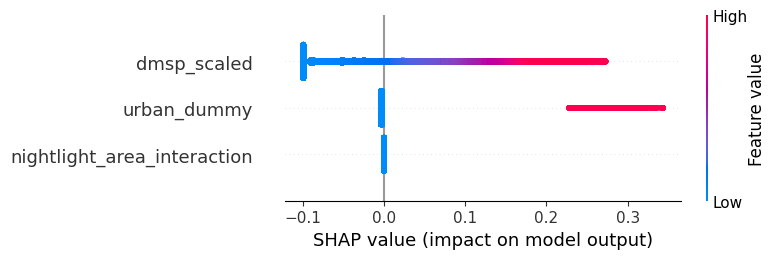

In [25]:
# SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=features)


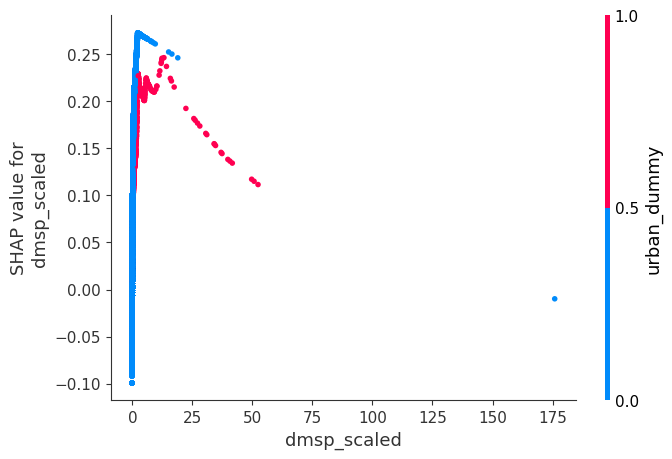

In [26]:
# SHAP dependence plot for Nightlight Intensity
shap.dependence_plot(0, shap_values.values, X_test, feature_names=features)

14186/14186 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/plots/_force_matplotlib.py:101: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


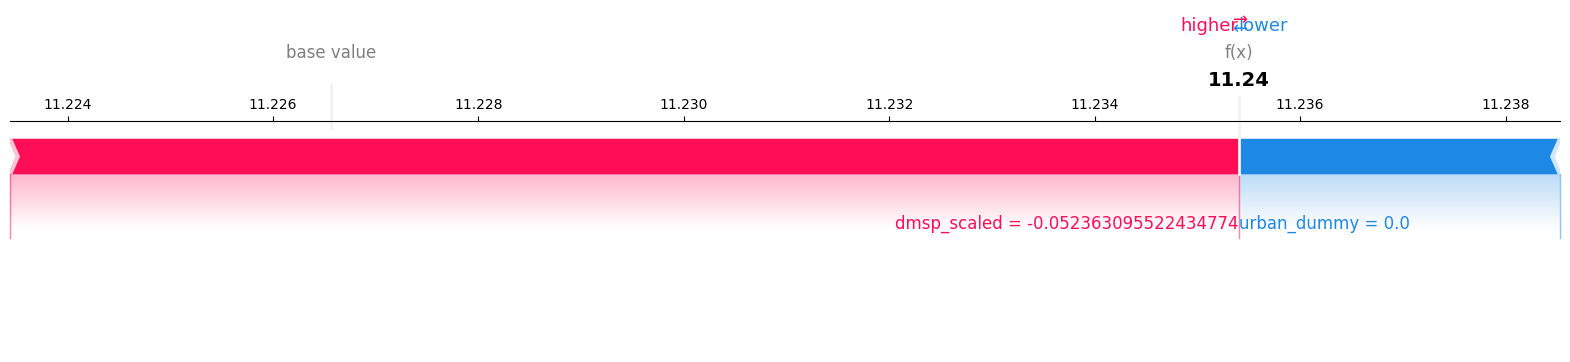

In [29]:
# Compute the base value (mean prediction of training set)
base_value = model.predict(X_train).mean()

# Pick a random test instance
random_index = np.random.randint(0, X_test.shape[0])

# Generate force plot
shap.force_plot(
    base_value, 
    shap_values[random_index].values, 
    X_test[random_index], 
    feature_names=features, 
    matplotlib=True
)


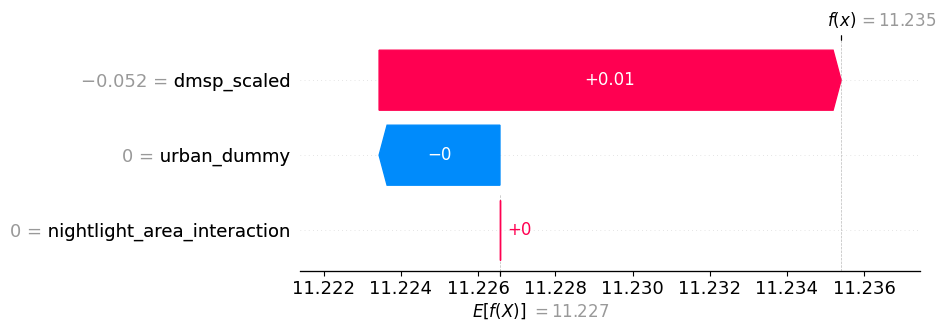

In [30]:
# Generate waterfall plot for a single prediction
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[random_index].values, 
        base_values=base_value,  # Use computed base value
        data=X_test[random_index], 
        feature_names=features
    )
)
